# MASH results on V8 data
In comparison with those on V6 data.

Previously I've computed for top eQTLs MASH posteriors using the `mashr-paper` version package. Here I explore results from a later run on V8 data using the refactored `mashr`, and compare results with previous analysis.

In [ ]:
library(lattice)
library(ggplot2)
library(colorRamps)
library(mashr)

## MASH model fit

In [8]:
hm = readRDS('~/Documents/GTExV8/MASH/GTExV8.ciseQTL.4MASH.cov.K5.P5.mash_model.rds')

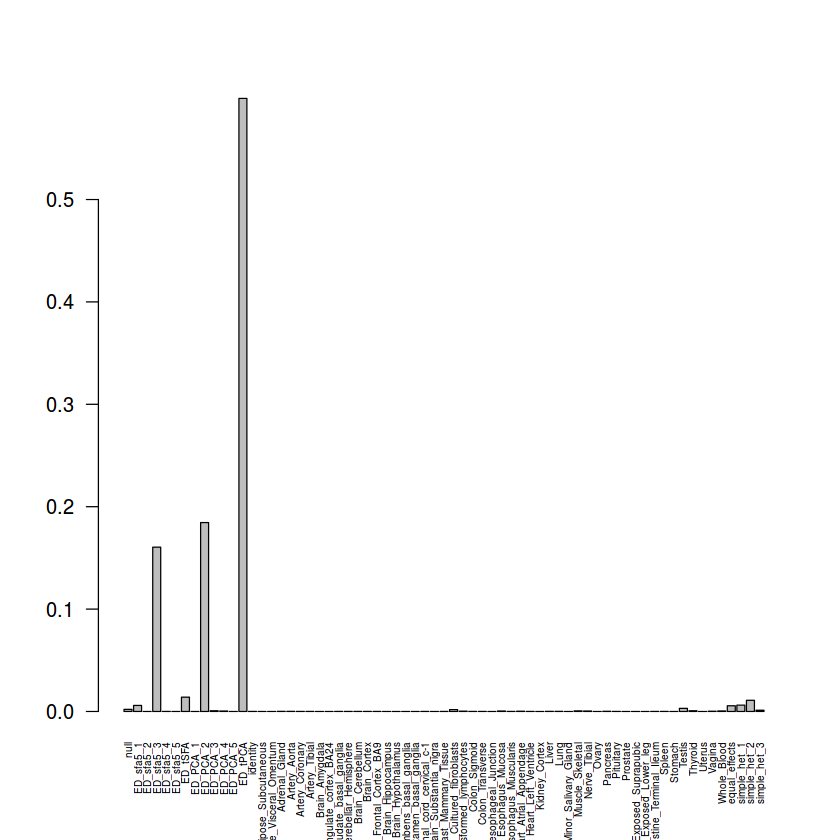

In [9]:
pis = get_estimated_pi(hm)
barplot(pis,las = 2,cex.names = 0.5)

## Posterior quantities

In [10]:
p = readRDS('~/Documents/GTExV8/MASH/GTExV8.ciseQTL.4MASH.cov.K5.P5.mash_posterior.rds')
str(p)

List of 5
 $ PosteriorMean: num [1:15632, 1:49] 4.93 -1.81 -5.27 -4.16 3.4 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : chr [1:15632(1d)] "ENSG00000000003_X_100674535_G_C" "ENSG00000000419_20_50685681_CAT_C" "ENSG00000000457_1_169788346_A_C" "ENSG00000000460_1_169789148_T_G" ...
  .. ..$ : chr [1:49(1d)] "Adipose_Subcutaneous" "Adipose_Visceral_Omentum" "Adrenal_Gland" "Artery_Aorta" ...
 $ PosteriorSD  : num [1:15632, 1:49] 0.944 0.776 0.9 0.939 0.288 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : chr [1:15632(1d)] "ENSG00000000003_X_100674535_G_C" "ENSG00000000419_20_50685681_CAT_C" "ENSG00000000457_1_169788346_A_C" "ENSG00000000460_1_169789148_T_G" ...
  .. ..$ : chr [1:49(1d)] "Adipose_Subcutaneous" "Adipose_Visceral_Omentum" "Adrenal_Gland" "Artery_Aorta" ...
 $ lfdr         : num [1:15632, 1:49] 2.78e-169 2.47e-14 2.31e-164 1.18e-184 5.99e-49 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : chr [1:15632(1d)] "ENSG00000000003_X_100674535_G_C" "ENSG00000000419_20_506856

## Data-driven patterns of sharing